In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
import os

#Parameters
input_size = 784
hidden_size = 400
latent_size = 2



# Define the VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        #return mu + std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, input_size), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing
batch_size = 512

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10

# Load the model
file_name = "vae_mnist_v3_1.pth"
load_pretrained = True

if load_pretrained:
    if os.path.exists(file_name):
        model.load_state_dict(torch.load(file_name))
        print("Loaded pretrained model.")

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# Save the model
torch.save(model.state_dict(), file_name)


Loaded pretrained model.
Epoch 1/10, Loss: 37.0610
Epoch 2/10, Loss: 36.9758
Epoch 3/10, Loss: 36.9150
Epoch 4/10, Loss: 36.9165
Epoch 5/10, Loss: 36.8753
Epoch 6/10, Loss: 36.8389
Epoch 7/10, Loss: 36.8016
Epoch 8/10, Loss: 36.7726
Epoch 9/10, Loss: 36.7535
Epoch 10/10, Loss: 36.6896


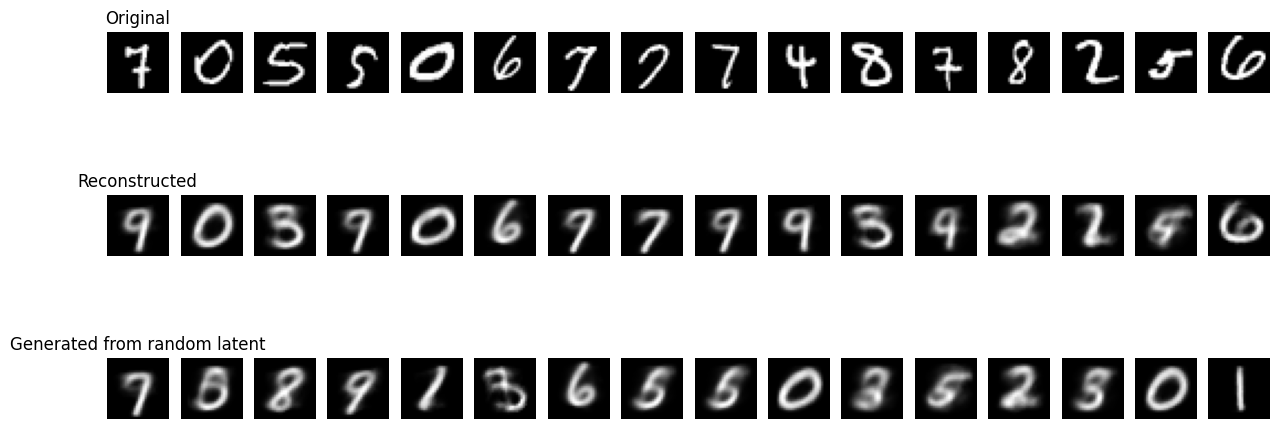

In [3]:
import matplotlib.pyplot as plt

# Function to visualize original, reconstructed, and generated samples
def visualize_results(model, data_loader, num_samples=16):
    model.eval()
    
    # Get a batch of real data
    data, _ = next(iter(data_loader))
    data = data[:num_samples]

    # Reconstruct data
    with torch.no_grad():
        recon, _, _ = model(data.to(device))

    # Generate from random latent vectors
    z = torch.randn(num_samples, latent_size).to(device)
    generated_samples = model.decode(z)

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

    for ax, img, recon_img, gen_img in zip(axes.T, data, recon, generated_samples):
        ax[0].imshow(img[0].cpu().numpy(), cmap='gray')
        ax[1].imshow(recon_img.view(28, 28).cpu().numpy(), cmap='gray')
        ax[2].imshow(gen_img.view(28, 28).detach().cpu().numpy(), cmap='gray')

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    axes[2, 0].set_title('Generated from random latent')

    plt.show()

visualize_results(model, train_loader)


In [ ]:
import torch
from torchviz import make_dot

# ... [your VAE model definition and loss function here] ...

# Dummy input data
x = torch.randn((batch_size, input_size))

# Model and optimizer
model = VAE()
optimizer = torch.optim.Adam(model.parameters())

# Forward pass
recon_x, mu, logvar = model(x)
loss = vae_loss(recon_x, x, mu, logvar)

# Visualize the computation graph
dot = make_dot(loss, params=dict(model.named_parameters()))
dot.view()  # This will generate and display a .pdf file showing the computation graph


In [4]:
# To store latent values and labels
latent_values = []
labels = []

with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, input_size))
        latent_values.append(mu.cpu())
        labels.append(label)

latent_values = torch.cat(latent_values, dim=0)
labels = torch.cat(labels, dim=0)


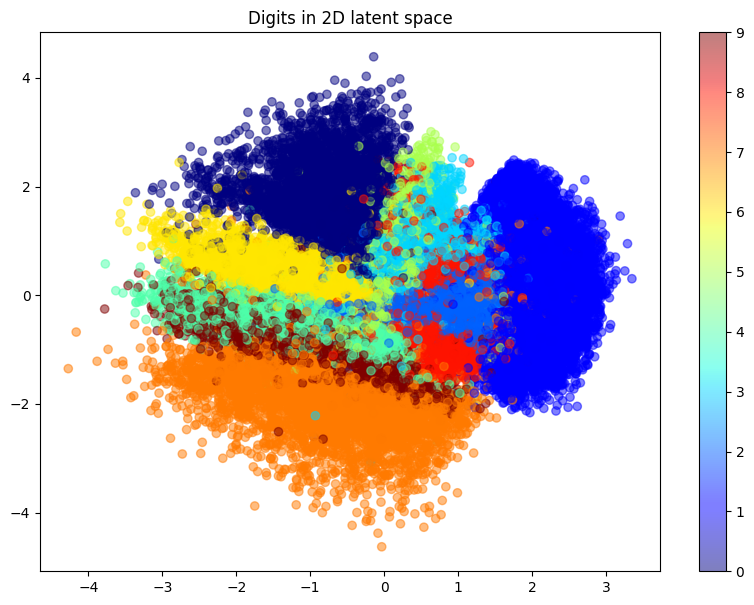

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_values[:, 0], latent_values[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.colorbar(scatter)
plt.title("Digits in 2D latent space")
plt.show()


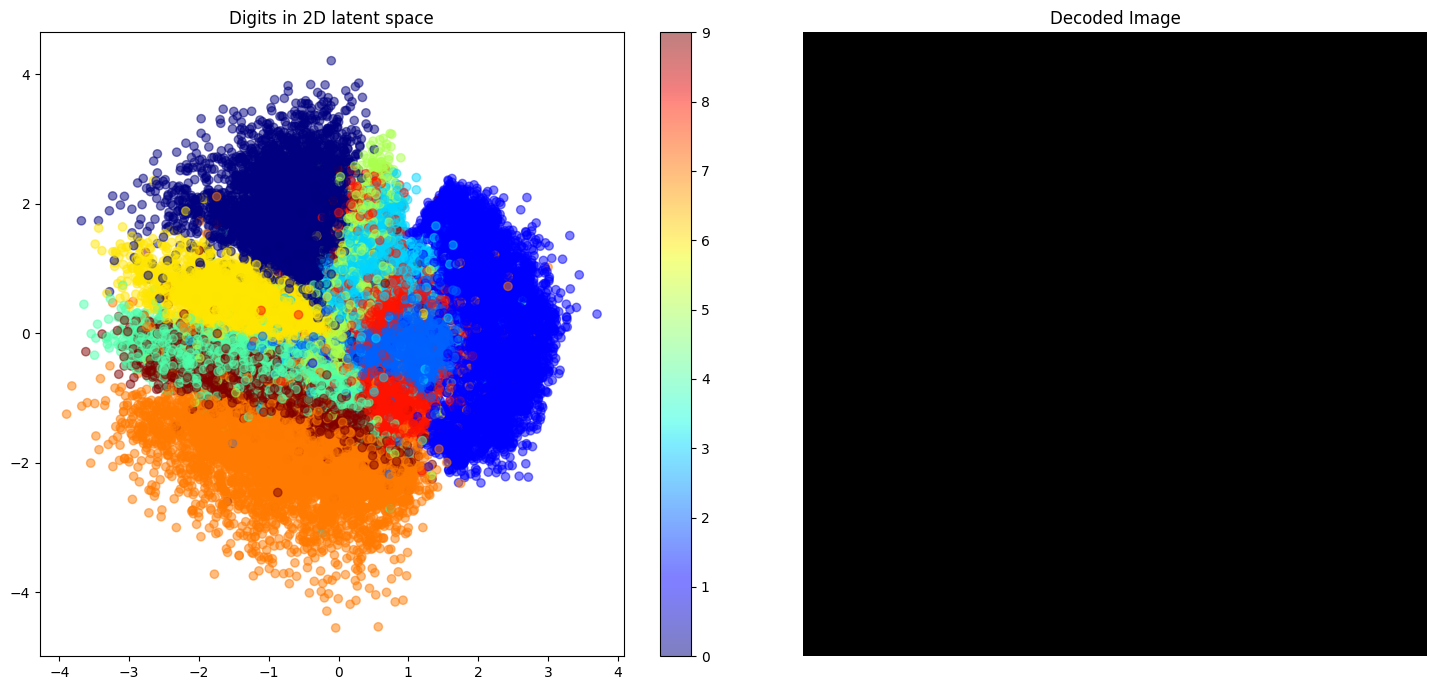

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def decode_from_latent_space(x, y, decoder):
    latent_point = torch.tensor([[x, y]], device=device)
    with torch.no_grad():
        decoded_image = decoder(latent_point)
    return decoded_image.view(28, 28).cpu().numpy()

def onpick(event):
    ind = event.ind[0]
    x, y = latent_values[ind]
    decoded_img = decode_from_latent_space(x, y, model.decode) # Assuming 'vae_model.decode' is the method to decode latent points

    ax2.clear()
    ax2.imshow(decoded_img, cmap='gray')
    ax2.axis('off')
    ax2.set_title(f"Decoded Image for ({x:.2f}, {y:.2f})")
    fig.canvas.draw()
    print(f"Label: {labels[ind].item()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot the latent values on ax1
sc = ax1.scatter(latent_values[:, 0], latent_values[:, 1], c=labels, cmap='jet', alpha=0.5, picker=True) # Enable picking on the scatter plot
plt.colorbar(sc, ax=ax1)
ax1.set_title("Digits in 2D latent space")

# Initially set a placeholder image on ax2
placeholder = np.zeros((28, 28))
ax2.imshow(placeholder, cmap='gray')
ax2.axis('off')
ax2.set_title("Decoded Image")

#fig.canvas.mpl_connect('pick_event', onpick)
fig.canvas.mpl_connect('motion_notify_event', onpick)

plt.tight_layout()
plt.show()


In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output
model.eval()
# Define a function that takes 20 arguments (one for each slider/latent dimension)
def visualize_latent(z1, z2):
    z = torch.tensor([z1, z2]).float().to(device)
    with torch.no_grad():
        decoded_img = model.decode(z).view(28, 28).cpu().numpy()  # Assuming your images are 28x28
    
    # Display the output image
    clear_output(wait=True)
    plt.imshow(decoded_img, cmap='gray')
    plt.axis('off')
    plt.show()

# Create the sliders
sliders = {
    f'z{i+1}': widgets.FloatSlider(min=-5, max=5, step=0.1, value=0, description=f'z{i+1}') 
    for i in range(2)
}
def reset_sliders(button):
    for slider in sliders.values():
        slider.value = 0

reset_button = widgets.Button(description="Reset Sliders")
reset_button.on_click(reset_sliders)

# Define the layout for the GridBox
grid_layout = widgets.Layout(
    width='100%',
    grid_template_columns='repeat(2, 1fr)',  # 4 columns with equal width    
    grid_gap='10px'                           # spacing between sliders
)

# Create the GridBox with sliders
grid = widgets.GridBox(list(sliders.values()), layout=grid_layout)
ui = widgets.VBox([grid, reset_button])
out = widgets.interactive_output(visualize_latent, sliders)
display(ui, out)



Output()

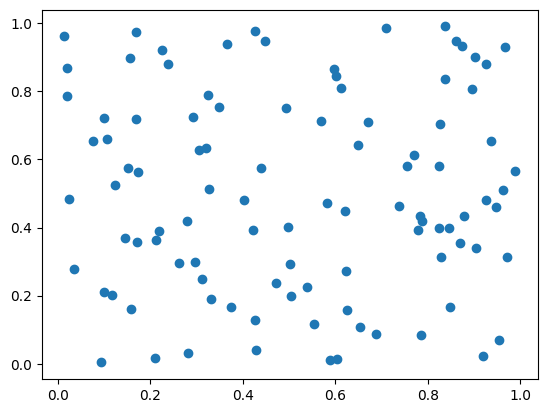

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample latent values
latent_values2 = np.random.rand(100, 2)

def on_click(event):
    # Capture x and y coordinates
    ix, iy = event.xdata, event.ydata
    print(f'x = {ix}, y = {iy}')
    
    # Here you can use ix and iy to render your model output
    # model_output = some_function(ix, iy)
    # ...

fig, ax = plt.subplots()
ax.scatter(latent_values2[:, 0], latent_values2[:, 1])

# Connecting the click event to the callback function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

plt.show()